In [3]:
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import math

## Bolt Object

In [4]:
class Bolt:
    """
    Bolt object definition
    
    Input Arguments:
        tag              an unique ID for each bolt
        x                absolute x coordinate
        y                absolute y coordinate
        
    Attributes:
        dx               x distance from CG to bolt (x - x_cg)
        dy               y distance from CG to bolt (y - y_cg)
        ro               Euclidean distance from CG to bolt
        
        vx_direct        shear demand in x direction due to direct shear
        vy_direct        shear demand in y direction due to direct shear
        vx_torsion       shear demand in x direction due to torsion
        vy_torsion       shear demand in y direction due to torsion
        vx_total         shear demand in x direction total
        vy_total         shear demand in y direction total
        v_resultant      shear demand total vector sum
        v_theta          shear vector angle with respect to horizontal
        
        dx_ICR           x distance from ICR to bolt (x - x_ICR)
        dy_ICR           y distance from ICR to bolt (y - y_ICR)
        ro_ICR           Euclidean distance from ICR to bolt
        theta_ICR        angle of line from bolt to ICR with respect to horizontal
        m_ICR            moment contribution of this bolt
        
    Public Methods:
        None
    """
    def __init__(self, tag, x, y):
        self.tag = tag
        self.x = x
        self.y = y
        self.dx = None
        self.dy = None
        self.ro = None
        
        # for elastic method
        self.vx_direct = None
        self.vy_direct = None
        self.vx_torsion = None
        self.vy_torsion = None
        self.vx_total = None
        self.vy_total = None
        self.v_resultant = None
        self.v_theta = None
        self.dx_elastic = None
        self.dy_elastic = None
        self.ro_elastic = None
        
        # for instant center of rotation method
        self.dx_ICR = []
        self.dy_ICR = []
        self.ro_ICR = []
        self.vx_ICR = []
        self.vy_ICR = []
        self.vresultant_ICR = []
        self.theta_ICR = []
        self.m_ICR = []

    def update_geometry(self, x_cg, y_cg):
        """update geometry with respect to bolt group CG"""
        self.dx = self.x - x_cg
        self.dy = self.y - y_cg
        self.ro = (self.dx**2 + self.dy**2)**(1/2)
        
    def update_geometry_elastic(self, x_elastic_ICR, y_elastic_ICR):
        """update geometry with respect to elastic center of rotation"""
        self.dx_elastic = self.x - x_elastic_ICR
        self.dy_elastic = self.y - y_elastic_ICR
        self.ro_elastic = (self.dx_elastic**2 + self.dy_elastic**2)**(1/2)
    
    def update_forces_elastic(self, Vx, Vy, N_bolt, torsion, Iz):
        """compute bolt demands using elastic method"""
        self.vx_direct = -Vx / N_bolt
        self.vy_direct = -Vy / N_bolt
        self.vx_torsion = torsion * self.dy / Iz
        self.vy_torsion = -torsion * self.dx / Iz
        self.vx_total = self.vx_direct + self.vx_torsion
        self.vy_total = self.vy_direct + self.vy_torsion
        self.v_resultant = (self.vx_total**2 + self.vy_total**2)**(1/2)
        self.v_theta = math.atan2(self.vy_total,self.vx_total) * 180 / math.pi
        
    def update_forces_ICR(self, ICR_x, ICR_y, rmax, solution_found=False):
        """given a ICR location, compute bolt forces to see if equilibrium is established"""
        D_ULT = 0.34  # in. maximum bolt deformation
        F_ULT = 74  # kip. corresponding force. Cancels out in computing C
        dx_ICR = self.x - ICR_x
        dy_ICR = self.y - ICR_y
        ro_ICR = (dx_ICR**2 + dy_ICR**2)**(1/2)
        theta_ICR = (math.atan2(dy_ICR, dx_ICR) * 180 / math.pi)
        v_theta = theta_ICR - 90  # perpendicular
        
        deformation = r_ICR / rmax * D_ULT
        force = F_ULT * (1-math.exp(-10*deformation))**(0.55)
        force_x = force * math.cos(math.radians(v_theta))
        force_y = force * math.sin(math.radians(v_theta))
        moment_z = force * r_ICR
        
        if solution_found:
            self.dx_ICR = dx_ICR
            self.dy_ICR = dy_ICR
            self.ro_ICR = ro_ICR
            self.theta_ICR = theta_ICR
            self.m_ICR = moment_z
            self.vx_total = force_x
            self.vy_total = force_y
            self.v_resultant = force
            self.v_theta = v_theta
        
        return force_x, force_y, moment_z
        

## BoltGroup Object

In [66]:
class BoltGroup:
    """
    Bolt group object definition
    
    Input Arguments:
        None               
        
    Attributes:
        bolts
        N_bolts
        x_cg
        y_cg
        Ix
        Iy
        Iz
        rn
        
        Vx
        Vy
        V_resultant
        torsion
        ecc
        theta
        
        ICR_xi
        ICR_yi
        ICR_Ci
        sumFx
        sumFy
        sumMz
        
    Public Methods:
        add_bolt(x, y)
        solve(Vx, Vy, torsion, rn)
        preview()
        plot_forces()
        plot_ICR(xlim, ylim, du)
    """
    def __init__(self):
        # common to both method
        self.bolts = []
        self.N_bolt = 0
        self.x_cg = None
        self.y_cg = None
        self.Ix = None
        self.Iy = None
        self.Iz = None
        self.rn = None
        
        # for elastic method
        self.Vx = None
        self.Vy = None
        self.V_resultant = None
        self.torsion = None
        self.ecc = None
        self.theta = None
        
        # for instant center of rotation method
        self.ICR_ax = []
        self.ICR_ay = []
        self.ICR_xi = []
        self.ICR_yi = []
        self.ICR_Ci = []
        self.sumFx = []
        self.sumFy = []
        self.sumMz = []
        
    def add_bolt(self, x, y):
        """add a bolt at user-specified coordinate"""
        self.bolts.append(Bolt(self.N_bolt,x,y))
        self.N_bolt += 1
    
    def update_geometric_properties(self):
        """update bolt group geometry properties"""
        self.x_cg = sum([b.x / self.N_bolt for b in self.bolts])
        self.y_cg = sum([b.y / self.N_bolt for b in self.bolts])
        self.Ix = sum([(b.x - self.x_cg)**2 for b in self.bolts])
        self.Iy = sum([(b.y - self.y_cg)**2 for b in self.bolts])
        self.Iz = self.Ix + self.Iy
        for bolt in self.bolts:
            bolt.update_geometry(self.x_cg, self.y_cg)
        
    def solve(self, Vx, Vy, torsion, bolt_capacity=17.9):
        """solve for bolt shear and tension demand. In-plane forces only"""
        # Method 1 - elastic method (superposition)
        self.update_geometric_properties()
        self.Vx = Vx
        self.Vy = Vy
        self.torsion = torsion
        self.V_resultant = (Vx**2 + Vy**2)**(1/2)
        self.theta = math.atan2(Vy, Vx) * 180 / math.pi
        self.ecc = 0 if self.V_resultant==0 else torsion / self.V_resultant
        for bolt in self.bolts:
            bolt.update_forces_elastic(Vx=self.Vx, Vy=self.Vy, N_bolt=self.N_bolt, torsion=self.torsion, Iz=self.Iz)
        self.rn = bolt_capacity  # default = 17.9 kips for 3/4" A325N bolt in single shear
        rumax = max([b.v_resultant for b in self.bolts])
        print("Method 1 - Elastic method with superposition:")
        self.check_equilibrium_elastic()
        print("\t Maximum bolt shear demand = {:.2f} kips".format(rumax))
        print("\t Maximum bolt shear capacity = {:.2f} kips".format(self.rn))
        print("\t DCR = {:.2f}".format(rumax/self.rn))
        
        # Method 2 - elastic method (elastic instant center of rotation). See Brandt paper.
        ax = -Vy * self.Iz / self.torsion / self.N_bolt
        ay = Vx * self.Iz / self.torsion / self.N_bolt
        self.ICR_elastic_x = self.x_cg + ax
        self.ICR_elastic_y = self.y_cg + ay
        for bolt in self.bolts:
            bolt.update_geometry_elastic(self.ICR_elastic_x, self.ICR_elastic_y)
        sumdsquared = sum([b.ro_elastic**2 for b in self.bolts])
        dmax = max([b.ro_elastic for b in self.bolts])
        ecc_xnew = self.ecc * math.cos(math.radians(self.theta+90)) + ax
        ecc_ynew = self.ecc * math.sin(math.radians(self.theta+90)) + ay
        ecc_new = math.sqrt(ecc_xnew**2 + ecc_ynew**2)
        # ecc_unit = ecc ==> Mp / 1 = torsion/V_resultant. For unit load, Mp = ecc
        Mp = ecc_new
        Ce = sumdsquared / dmax / Mp
        Pmax = Ce * self.rn
        print("\nMethod 2 - Elastic method with equivalent center of rotation:")
        print("\t Elastic instant center of rotation found at ({:.2f}, {:.2f})".format(self.ICR_elastic_x, self.ICR_elastic_y))
        self.check_equilibrium_elastic2()
        print("\t Ce is equal to {:.2f}".format(Ce))
        print("\t With rn = {:.2f} kips: Pmax = Ce*rn = {:.2f} kips".format(self.rn, Pmax))
        print("\t Applied shear = {:.2f} kips, DCR = {:.2f}".format(self.V_resultant, self.V_resultant/Pmax))
        
        # Method 3 - instant center of rotation method (inelastic). See Brandt paper.
        print("\nMethod 3 - Instant center of rotation method:")
        if self.V_resultant == 0:  # special case with pure torsion
            pass
        else:
            tol = 0.001
            residual = 1
            iteration = 1
            ax = -Vy * self.Iz / self.torsion / self.N_bolt
            ay = Vx * self.Iz / self.torsion / self.N_bolt
            ICR_x = self.x_cg + ax
            ICR_y = self.y_cg + ay
            print("Searching for ICR using Brandt's method. Equilibrium checked with unit load")
            while residual > tol:
                
                
                
                sumFx, sumFy, sumMz = self.check_equilibrium_ICR(ICR_x, ICR_y)
                print("\t iteration {}: ICR=({:.2f}, {:.2f}). Cu = {:.2f}. sumFx = {:.2f}, sumFy = {:.2f}, sumMz = {:.2f}".format(iteration,                                                                                         ))
                self.ICR_ax.append(ax)
                self.ICR_ay.append(ay)
                self.ICR_xi.append(ICR_x)
                self.ICR_yi.append(ICR_y)
                self.ICR_Ci.append(Ci)
                self.sumFx.append(sumFx)
                self.sumFy.append(sumFy)
                self.sumMz.append(sumMz)
                iteration += 1
                ax = -sumFy * self.Iz / self.torsion / self.N_bolt
                ay = sumFx * self.Iz / self.torsion / self.N_bolt
                ICR_x = self.ICR_xi[-1] + ax
                ICR_y = self.ICR_yi[-1] + ay
                
            print("\t Tolerance achieved. Instant Center of rotation found at ({:.2f}, {:.2f})".format())
            print("\t Cu is equal to {:.2f}".format())
            print("\t With rn = {:.2f} kips: Pmax = Cu*rn = {:.2f} kips".format())
            print("\t Applied shear = {:.2f} kips, DCR = {:.2f}".format())
        
    def check_equilibrium_elastic(self):
        """check if summation of forces and moment is equal to zero for the elastic method"""
        sumFx = sum([b.vx_total for b in self.bolts]) + self.Vx
        sumFy = sum([b.vy_total for b in self.bolts]) + self.Vy
        sumMz = sum([b.vx_total*b.dy + b.vy_total*b.dx for b in self.bolts]) - self.torsion
        print("\t Checking equilibrium: ", end="")
        print("sumFx={:.1f}, sumFy={:.1f}, sumMz={:.1f}".format(sumFx, sumFy, sumMz))
        
    def check_equilibrium_elastic2(self):
        """check if summation of forces and moment is equal to zero about the elastic ICR"""
        sumFx = sum([b.vx_total for b in self.bolts]) + self.Vx
        sumFy = sum([b.vy_total for b in self.bolts]) + self.Vy
        ax = -self.Vy * self.Iz / self.torsion / self.N_bolt
        ay = self.Vx * self.Iz / self.torsion / self.N_bolt
        sumMz = sum([b.v_resultant*b.ro_elastic for b in self.bolts]) - self.torsion - self.Vx*ay + self.Vy*ax
        print("\t Checking equilibrium: ", end="")
        print("sumFx={:.1f}, sumFy={:.1f}, sumMz={:.1f}".format(sumFx, sumFy, sumMz))
        
    def check_equilibrium_ICR(self):
        """check summation of forces and moments for ICR method"""
        pass
        
    def preview(self):
        """preview bolt configuration"""
        self.update_geometric_properties()
        fig, axs = plt.subplots(figsize=[4,4])
        for bolt in self.bolts :
            axs.plot([bolt.x],[bolt.y], marker=".",c="blue",markersize=9,zorder=2,linestyle="none")
            axs.annotate("{}".format(bolt.tag), xy=(bolt.x, bolt.y), xycoords='data', xytext=(0, 5), textcoords='offset points', fontsize=10, c="blue")
        axs.plot(self.x_cg, self.y_cg, marker="x",c="black",markersize=6,zorder=2,linestyle="none")
        axs.annotate("CoG",xy=(self.x_cg, self.y_cg), xycoords='data', color="black",
                        xytext=(0, 5), textcoords='offset points', fontsize=12)
        xmin = min([b.x for b in self.bolts])
        xmax = max([b.x for b in self.bolts])
        ymin = min([b.y for b in self.bolts])
        ymax = max([b.y for b in self.bolts])
        bound = max([abs(xmin),abs(xmax),abs(ymin),abs(ymax)])
        axs.set_xlim([-bound*1.1, bound*1.1])
        axs.set_ylim([-bound*1.1, bound*1.1])
        axs.set_aspect('equal', 'box')
        plt.tight_layout()
    
    def plot_forces(self):
        """preview forces in each bolt"""
        fig, axs = plt.subplots(figsize=[6,6])
        
        # bolts
        for bolt in self.bolts:
            axs.plot([bolt.x],[bolt.y], marker=".",c="blue",markersize=9,zorder=2,linestyle="none")
            axs.annotate("vx = {:.2f} kips\nvy = {:.2f} kips\nvtotal = {:.2f} kips".format(bolt.vx_total, bolt.vy_total, bolt.v_resultant),
                         xy=(bolt.x, bolt.y), xycoords='data', 
                         xytext=(0, 5), textcoords='offset points', fontsize=10, c="blue")
        
        # center of gravity
        axs.plot(self.x_cg, self.y_cg, marker="x",c="black",markersize=6,zorder=2,linestyle="none")
        axs.annotate("Vx = {:.2f} kips\nVy = {:.2f} kips\nVtotal = {:.2f} kips\nMz = {:.2f} k.in".format(self.Vx, self.Vy, self.V_resultant, self.torsion),
                     xy=(self.x_cg, self.y_cg), xycoords='data', color="black",
                     xytext=(0, 5), textcoords='offset points', fontsize=10)
        
        # arrow size scaling
        ymin = min([b.y for b in self.bolts])
        ymax = max([b.y for b in self.bolts])
        Larrow_max = (ymax - ymin) * 0.15
        Qarrow_max = max([b.v_resultant for b in self.bolts]) if self.V_resultant==0 else self.V_resultant
        
        # applied force arrows
        if self.V_resultant != 0:
            #L_arrow = self.V_resultant / Qarrow_max * Larrow_max
            L_arrow = Larrow_max
            dx_arrow = L_arrow * math.cos(math.radians(self.V_theta))
            dy_arrow = L_arrow * math.sin(math.radians(self.V_theta))
            ecc_x = self.V_ecc * math.cos(math.radians(self.V_theta-90))
            ecc_y = self.V_ecc * math.sin(math.radians(self.V_theta-90))
            axs.arrow(self.x_cg + ecc_x, self.y_cg + ecc_y, dx_arrow, dy_arrow, 
                      width=0.01, head_width=0.2, head_length=0.2, fc='k', ec='k')
        
        # bolts reaction arrows
        for bolt in self.bolts:
            #L_arrow = bolt.v_resultant / Qarrow_max * Larrow_max
            L_arrow = Larrow_max
            dx_arrow = L_arrow * math.cos(math.radians(bolt.v_theta))
            dy_arrow = L_arrow * math.sin(math.radians(bolt.v_theta))
            axs.arrow(bolt.x, bolt.y, dx_arrow, dy_arrow, 
                      width=0.01, head_width=0.1, head_length=0.1, fc='blue', ec='blue')
        
        # ICR if applicable
        if self.solution_scheme == "ICR":
            axs.plot(self.ICR_x, self.ICR_y, marker="o",c="red",markersize=8,zorder=2,linestyle="none")
            axs.annotate("ICR",
                         xy=(self.ICR_x, self.ICR_y), xycoords='data', color="red",
                         xytext=(0, 5), textcoords='offset points', fontsize=12)
    
        axs.set_aspect('equal', 'box')
        plt.tight_layout()
        axs.autoscale_view()
        
    def plot_ICR(self, xlim, ylim, du=0.25):
        """preview ICR search space"""
        xmin = min([b.x for b in self.bolts])
        xmax = max([b.x for b in self.bolts])
        ymin = min([b.y for b in self.bolts])
        ymax = max([b.y for b in self.bolts])
        bound = abs(max([xmin,xmax,ymin,ymax], key=abs))
        
        X = np.arange(xlim[0], xlim[1], du)
        Y = np.arange(ylim[0], ylim[1], du)
        X_g, Y_g = np.meshgrid(X, Y)
        root_func_plot_v = np.vectorize(self.root_func_plot)
        Z = root_func_plot_v(X_g, Y_g)
        
        fig = go.Figure(data=[go.Surface(z=Z, x=X, y=Y)])
        fig.show()

In [67]:
boltgroup1 = BoltGroup()
boltgroup1.add_bolt(x=0, y=-3)
boltgroup1.add_bolt(x=0, y=0)
boltgroup1.add_bolt(x=0, y=3)

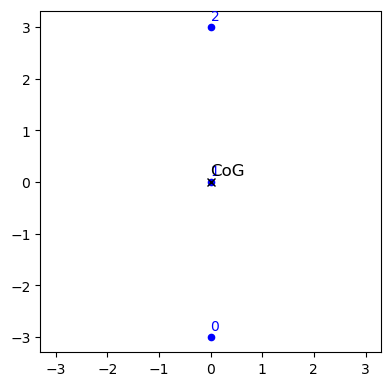

In [68]:
boltgroup1.preview()

In [71]:
boltgroup1.solve(Vx=0, Vy=24, torsion=96, bolt_capacity=17.9)

Method 1 - Elastic method with superposition:
	 Checking equilibrium: sumFx=0.0, sumFy=0.0, sumMz=0.0
	 Maximum bolt shear demand = 17.89 kips
	 Maximum bolt shear capacity = 17.90 kips
	 DCR = 1.00

Method 2 - Elastic method with elastic instant center of rotation:
	 Elastic instant center of rotation found at (-1.50, 0.00)
	 Checking equilibrium: sumFx=0.0, sumFy=0.0, sumMz=0.0
	 Ce is equal to 1.34
	 With rn = 17.90 kips: Pmax = Ce*rn = 24.02 kips
	 Applied shear = 24.00 kips, DCR = 1.00


In [ ]:
boltgroup1.plot_forces()

In [ ]:
boltgroup1.preview_ICR(xlim=[-4,4], ylim=[-4,4])

In [17]:
# Instant Center of Rotation Method (Brandt's Algorithm)
        # 1.) first find the elastic center
        
        
        
        
        
        if self.V_ecc == 0:
            pass
            # pure torsion. Special case where ICR = CG
        else:
            solution = sp.minimize(self.root_func, x0=[-3,-3])
            self.ICR_x = solution.x[0]
            self.ICR_y = solution.x[1]
            sumFx = 0
            sumFy = 0
            sumMz = 0
            rmax = max([((b.x-self.ICR_x)**2 + (b.y-self.ICR_y)**2)**(1/2) for b in self.bolts])
            for bolt in self.bolts:
                fx, fy, mz = bolt.update_forces_ICR(self.ICR_x, self.ICR_y, rmax, solution_found=True)
                sumFx += fx
                sumFy += fy
                sumMz += mz
            P_fx = sumFx / math.cos(math.radians(self.V_theta))
            P_fy = sumFy / math.sin(math.radians(self.V_theta))
            P_mz = sumMz / self.V_ecc
            
            print(f"Local minimum found at: ({self.ICR_x:.1f} in, {self.ICR_y:.1f} in)")
            print("\tPmax from sumFx = {:.2f} kips".format(P_fx))
            print("\tPmax from sumFy = {:.2f} kips".format(P_fy))
            print("\tPmax from sumMz = {:.2f} kips".format(P_mz))
            
            print("At current load magnitude and orientation:")
            print("\teccentricity = {:.2f} in".format(self.V_ecc))
            print("\ttheta = {:.2f} deg".format(self.V_theta))
            print("\tP_applied = {:.2f} kips".format(self.V_resultant))
            print("\tP_allowed = {:.2f} kips".format(P_fx))
            print("\tDCR = {:.2f}".format(self.V_resultant/P_fx))
            print("\tC = {:.2f}".format(P_fx/74))

IndentationError: unexpected indent (2227201224.py, line 8)

## Testing

In [ ]:
Z=boltgroup1.preview_ICR(xlim_factor=1, ylim_factor=1)

In [ ]:
Z